# Model for AFM Image Coverage By MLP With Features Extracted  Using Resnet18 Pretrained on ImageNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import *
from matplotlib import  style


import time
import os
import copy
import random

import pickle
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

 

# Load pre-trained ResNet model
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo

import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score  
from sklearn.metrics import mean_squared_error as mse


torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
batch_size = 100

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

"""## Get Data"""




In [4]:


with open("Data/WSe2_data_extract", "rb") as fp:   # Unpickling
    WSe2_data_extract = pickle.load(fp)
train_X = WSe2_data_extract['ImageNet']['train']['feature']
train_Y = WSe2_data_extract['ImageNet']['train']['target']

val_X = WSe2_data_extract['ImageNet']['val']['feature']
val_Y = WSe2_data_extract['ImageNet']['val']['target']

test_X = WSe2_data_extract['ImageNet']['test']['feature']
test_Y = WSe2_data_extract['ImageNet']['test']['target']

train_Y = np.array(np.array(train_Y).reshape(-1, 1))
val_Y = np.array(np.array(val_Y).reshape(-1, 1))
test_Y = np.array(np.array(test_Y).reshape(-1, 1))

In [5]:

class Dataset():
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs


  def __len__(self):
        'Denotes the total number of samples' 
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = self.list_IDs[index]
        y = self.labels[index]
        return X, y      
        
def data_loader_fn(X, Y, batch_size, shuffle, drop_last):
    data_tensor = torch.tensor(X, dtype=torch.float32)    #all_img test_x, test_y
    target_tensor = torch.tensor(Y, dtype = torch.float32)   #target

    dataset = Dataset(data_tensor, target_tensor)
    data_loader = DataLoader(dataset,  batch_size = batch_size, shuffle = shuffle, drop_last=drop_last)#model_micro.eval()
    return data_loader


batch_size=16
train_loader = data_loader_fn(train_X, train_Y, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = data_loader_fn(val_X, val_Y, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = data_loader_fn(test_X, test_Y, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:


in1 =train_X.shape[1]        
class MLP(nn.Module):
    def __init__(self, l1=120, l2=84, p = 0.45):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in1, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 1)
        #self.activ = torch.nn.Sigmoid()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x



model = MLP()
model.to(device)

import torch.optim as optim


#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
mae = nn.L1Loss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.000225)#, 

In [5]:


def train_model_full(model, optimizer, criterion, epochs, error_value=0.052, error_margin=0):
    running_loss_list = []
    val_running_loss_list = []
    mean_abs_error_list = []
    val_mean_abs_error_list = []


    performance_record = {'train': {'loss': [], 'mae': []}, 'val': {'val_loss': [], 'val_mae': []}}
    for epoch in range(1, epochs):  # loop over the dataset multiple times  3001th 3501

        true_train = []
        pred_train = []

        true_val = []
        pred_val = []    

        #model_micro.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward  + optimize

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            true_train += labels.cpu().tolist()
            pred_train += outputs.cpu().tolist()



        #model_micro.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                true_val += labels.cpu().tolist()
                pred_val += outputs.cpu().tolist()

        train_mae = mae(true_train, pred_train)
        train_rmse = np.sqrt(mse(true_train,pred_train))

        val_mae = mae(true_val, pred_val)
        val_rmse = np.sqrt(mse(true_val,pred_val))



        running_loss_list.append(float(f'{train_rmse:.4f}'))
        val_running_loss_list.append(float(f'{val_rmse:.4f}'))
        mean_abs_error_list.append(float(f'{train_mae:.4f}'))
        val_mean_abs_error_list.append(float(f'{val_mae:.4f}'))
        print(f'Epoch{epoch}: rmse: {train_rmse:.4f} val_rmse: {val_rmse :.4f}, mae: {train_mae:.4f} val_mae: {val_mae:.4f}')

        if train_mae <= error_value-error_margin and val_mae <= error_value-error_margin:
            break
    performance_record['train']['loss'] += running_loss_list
    performance_record['train']['mae'] += mean_abs_error_list
    performance_record['val']['val_loss'] += val_running_loss_list
    performance_record['val']['val_mae']  += val_mean_abs_error_list

    return model, performance_record


In [6]:


model = MLP()
model.to(device)
criterion = nn.MSELoss()


optimizer = optim.Adam(model.parameters(), lr=0.000225)#
epochs = 3501
model, performance_record = train_model_full(model, optimizer, criterion, epochs)    

Epoch1: rmse: 0.2593 val_rmse: 0.2132, mae: 0.2127 val_mae: 0.1693
Epoch2: rmse: 0.2262 val_rmse: 0.2000, mae: 0.1778 val_mae: 0.1515
Epoch3: rmse: 0.2048 val_rmse: 0.1765, mae: 0.1554 val_mae: 0.1321
Epoch4: rmse: 0.1929 val_rmse: 0.1759, mae: 0.1416 val_mae: 0.1324
Epoch5: rmse: 0.1873 val_rmse: 0.1704, mae: 0.1352 val_mae: 0.1279
Epoch6: rmse: 0.1803 val_rmse: 0.1591, mae: 0.1289 val_mae: 0.1143
Epoch7: rmse: 0.1730 val_rmse: 0.1672, mae: 0.1204 val_mae: 0.1162
Epoch8: rmse: 0.1717 val_rmse: 0.1822, mae: 0.1185 val_mae: 0.1349
Epoch9: rmse: 0.1662 val_rmse: 0.1485, mae: 0.1150 val_mae: 0.1070
Epoch10: rmse: 0.1594 val_rmse: 0.1416, mae: 0.1059 val_mae: 0.1000
Epoch11: rmse: 0.1543 val_rmse: 0.1422, mae: 0.1014 val_mae: 0.1028
Epoch12: rmse: 0.1515 val_rmse: 0.1587, mae: 0.0996 val_mae: 0.1178
Epoch13: rmse: 0.1523 val_rmse: 0.1368, mae: 0.1000 val_mae: 0.0960
Epoch14: rmse: 0.1411 val_rmse: 0.1332, mae: 0.0887 val_mae: 0.0941
Epoch15: rmse: 0.1388 val_rmse: 0.1296, mae: 0.0868 val_m

In [7]:
val_acc_values = performance_record['val']['val_mae']
min_val = 0.6
position = 0
for index, item in enumerate(val_acc_values):
    if item < min_val:
        min_val = item
        position = index
print('position: ', position, 'min_val: ', min_val)

position:  938 min_val:  0.0511


In [7]:
with open("Models/performance_MLP_ImageNet", "wb") as fp:   #Pickling
  pickle.dump(performance_record, fp)
  
# to save model
PATH = 'Models/model_MLP_ImageNet.pth'
torch.save(model.state_dict(), PATH)


In [7]:
# specify path
PATH = 'Models/model_MLP_ImageNet.pth'
# to load model

#model = model_micro()
model.load_state_dict(torch.load(PATH))
model.eval()

MLP(
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (dropout): Dropout(p=0.45, inplace=False)
)

In [2]:
with open("Models/performance_MLP_ImageNet", "rb") as fp:   #Pickling
   performance_record = pickle.load(fp)

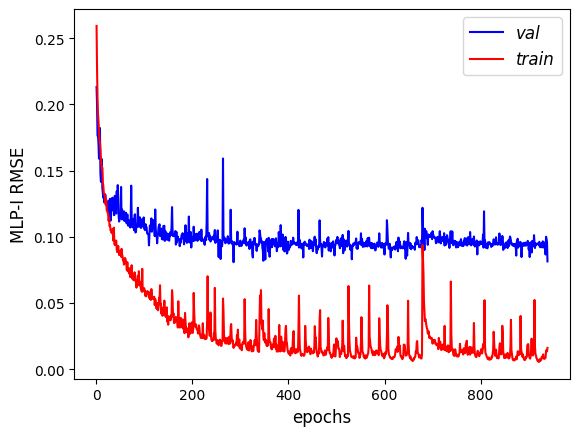

In [3]:

#mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings


history_dict = performance_record
loss_values = history_dict['train']['loss']
val_loss_values = history_dict['val']['val_loss']

acc_values = history_dict['train']['mae']
val_acc_values = history_dict['val']['val_mae']
epochs = range(1, len(acc_values) + 1)
N = 200



fig, ax1 = plt.subplots()
rc('axes', linewidth=1.2)
plt.rcParams['font.size'] = '12'
#plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.style'] = 'italic'
plt.xlabel('epochs', size=12)
plt.ylabel('MLP-I RMSE', size=12)

#plt.style.use("bmh")

#plt.rcParams.update({'figure.figsize': (12.0, 8.0)})


left, bottom, width, height = [0.39, 0.55, 0.5, 0.32]


ax1.plot(range(1, len(val_loss_values) + 1), val_loss_values, 'b', label = 'val')
ax1.plot(range(1, len(loss_values) + 1), loss_values, 'r', label = 'train')


#ax1.grid(axis='y')


plt.legend()

plt.savefig("Results/MLP_ImageNet_loss.png", dpi=600)
plt.show()

In [8]:
train_loader = data_loader_fn(train_X, train_Y, batch_size=batch_size, shuffle=False, drop_last=False)
val_loader = data_loader_fn(val_X, val_Y, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = data_loader_fn(test_X, test_Y, batch_size=batch_size, shuffle=False, drop_last=False)

In [9]:


def model_inference(dataloader, model):
    model.eval()
    true_test = []
    pred_test = []

    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)


            true_test += labels.cpu().tolist()
            pred_test += outputs.cpu().tolist()

        test_mae = mae(true_test, pred_test)
        test_rmse = np.sqrt(mse(true_test,pred_test))
        
        
    return true_test, pred_test, test_mae, test_rmse



In [10]:
true_test, pred_test, test_mae, test_rmse = model_inference(test_loader, model)

true_val, pred_val, val_mae, val_rmse = model_inference(val_loader, model)

true_train, pred_train, train_mae, train_rmse = model_inference(train_loader, model)


print(test_mae)
print(test_rmse)

print(val_mae)
print(val_rmse)


print(train_mae)
print(train_rmse)

0.06648463205150935
0.10104263052992032
0.05641445752722447
0.09683629818754665
0.008411908848457784
0.012406314824640104


In [11]:
test_r2_score = r2_score(true_test, pred_test)
val_r2_score = r2_score(true_val, pred_val)
train_r2_score = r2_score(true_train, pred_train)

print('train: ', train_r2_score, 'val: ', val_r2_score, 'test: ', test_r2_score)

train:  0.9984593404127737 val:  0.9047467122120881 test:  0.8730699124492632


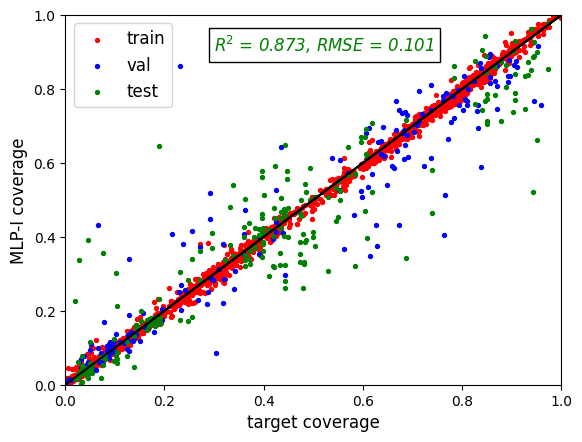

In [19]:
#Test

mpl.rcParams.update(mpl.rcParamsDefault) # this is to clear figure settings

fig, ax1 = plt.subplots()

#rc('axes', linewidth=1.2)
plt.rcParams['font.size'] = '12'


train_r2_score = r2_score(true_train, pred_train)
plt.xlabel('target coverage' , fontsize=12)#, fontweight='bold')
plt.ylabel('MLP-I coverage' , fontsize=12)#, fontweight='bold')
x_point = 0.3
y_point = 0.9
plt.text(x_point, y_point, f'R$^2$ = {test_r2_score:.3f}, RMSE = {test_rmse:.3f}', style='italic', color = 'g', bbox = {'facecolor': 'white'}
,fontsize = 12)
#plt.text(x_point, y_point, 'R$^2$ = 0.986, RMSE = 0.046 \n MAE = 0.037 $\pm$ 0.030', style='italic', color = 'b', bbox = {'facecolor': 'white'},fontsize = 15)
plt.xlim([0, 1])
plt.ylim([0, 1])


ax1.scatter(true_train, pred_train, color = 'r', s=8, label='train')
ax1.scatter(true_val, pred_val, color = 'b', s=8, label='val')
ax1.scatter(true_test, pred_test, color = 'g', s=8, label='test')
ax1.plot(true_train, true_train, 'black')
plt.legend()
plt.savefig("Results/MLP_Image_coverage_train_val_test.png", dpi=600)
plt.savefig("Results/MLP_Image_coverage_train_val_test.pdf", format="pdf", bbox_inches="tight")
plt.show()
